In [5]:
# %pip install pandas numpy librosa zipfile36 urllib3 scikit-learn matplotlib seaborn

In [14]:
import os
import zipfile
import requests
import io
import numpy as np
import pandas as pd
import librosa
import librosa.display
import matplotlib.pyplot as plt
import soundfile as sf
from IPython.display import Audio, display

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import (accuracy_score, f1_score, recall_score, classification_report, 
                            confusion_matrix, roc_auc_score, roc_curve)
import warnings
warnings.filterwarnings('ignore')

In [15]:
url = "https://github.com/Emmanuel-kwizera/ML-Pipeline-formative-2/raw/main/data/Audio_files.zip"

print("Downloading zip file...")
response = requests.get(url, verify=True)
response.raise_for_status()

print("Download complete!")

with zipfile.ZipFile(io.BytesIO(response.content)) as z:
    z.extractall("../data/audio_data")

print("Unzip complete!")


Download complete!
Unzip complete!


In [18]:
# Get All Audio Files and Organize by Speaker
audio_files = []
for root, dirs, files in os.walk("../data/audio_data"):
    for file in files:
        if file.endswith(('.wav', '.mp3', '.flac', '.ogg', '.m4a')):
            audio_files.append(os.path.join(root, file))

# Sort files alphabetically by filename for consistent ordering
audio_files.sort(key=lambda x: os.path.basename(x))

print(f"\nFound {len(audio_files)} audio files")
print("\n" + "="*60)
print("ORGANIZED AUDIO FILES")
print("="*60)

# Group by speaker name for better organization
from collections import defaultdict
speakers = defaultdict(list)

for file in audio_files:
    filename = os.path.basename(file)
    # Extract speaker name (everything before _Voice)
    speaker_name = filename.split('_Voice')[0]
    speakers[speaker_name].append(file)

# Display organized by speaker
for speaker in sorted(speakers.keys()):
    print(f"\n{speaker}:")
    for file in speakers[speaker]:
        print(f"  - {os.path.basename(file)}")

print("\n" + "="*60)
print("ALL FILES IN ORDER:")
print("="*60)
for i, file in enumerate(audio_files):
    print(f"{i}: {os.path.basename(file)}")


Found 8 audio files

ORGANIZED AUDIO FILES

Antony:
  - Antony_Voice 1.m4a
  - Antony_Voice 2.m4a

Charlotte:
  - Charlotte_Voice 1.m4a
  - Charlotte_Voice 2.m4a

Emmanuel:
  - Emmanuel_Voice 1.m4a
  - Emmanuel_Voice 2.m4a

Honorine:
  - Honorine_Voice 1.m4a
  - Honorine_Voice 2.m4a

ALL FILES IN ORDER:
0: Antony_Voice 1.m4a
1: Antony_Voice 2.m4a
2: Charlotte_Voice 1.m4a
3: Charlotte_Voice 2.m4a
4: Emmanuel_Voice 1.m4a
5: Emmanuel_Voice 2.m4a
6: Honorine_Voice 1.m4a
7: Honorine_Voice 2.m4a



VISUALIZING ALL AUDIO FILES


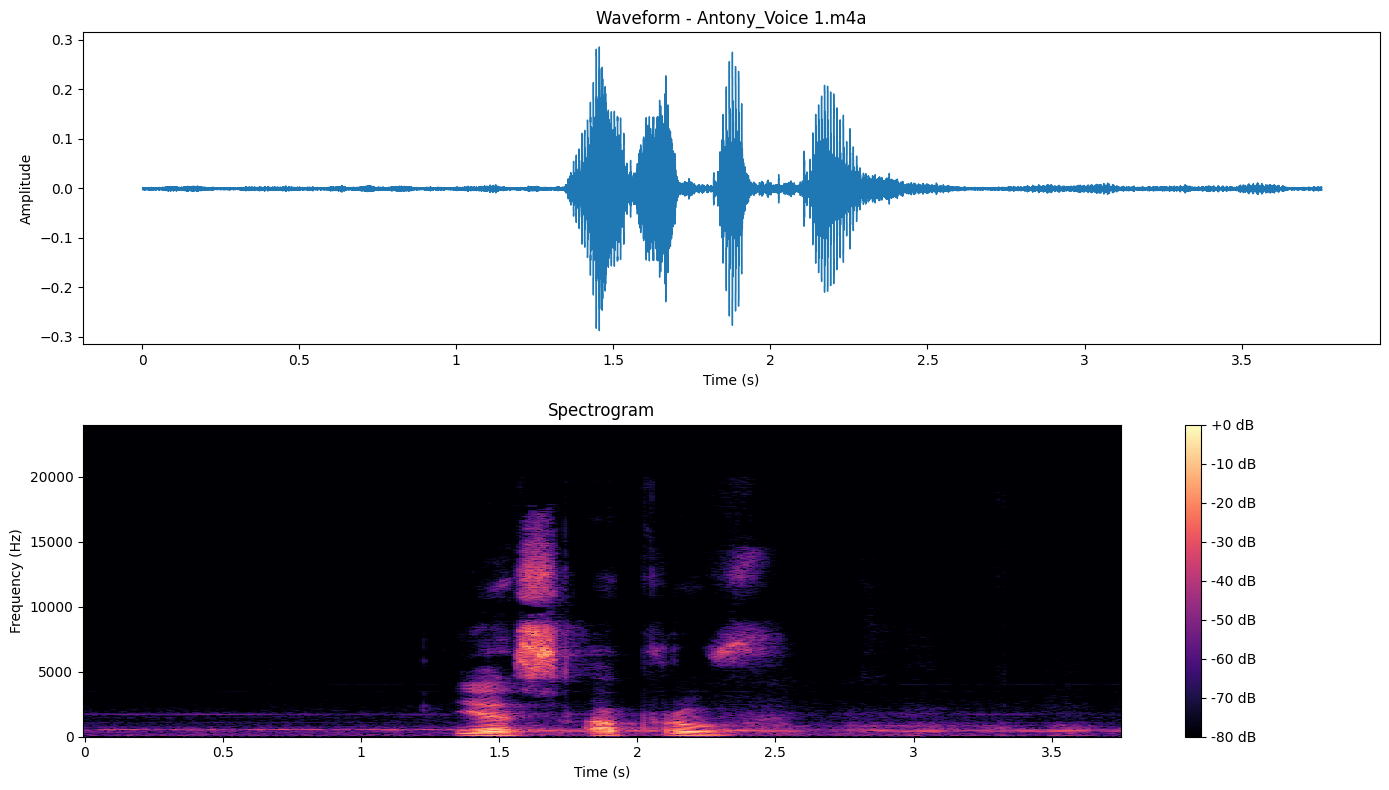

Audio player for: Antony_Voice 1.m4a


Duration: 3.75s, Sample Rate: 48000Hz



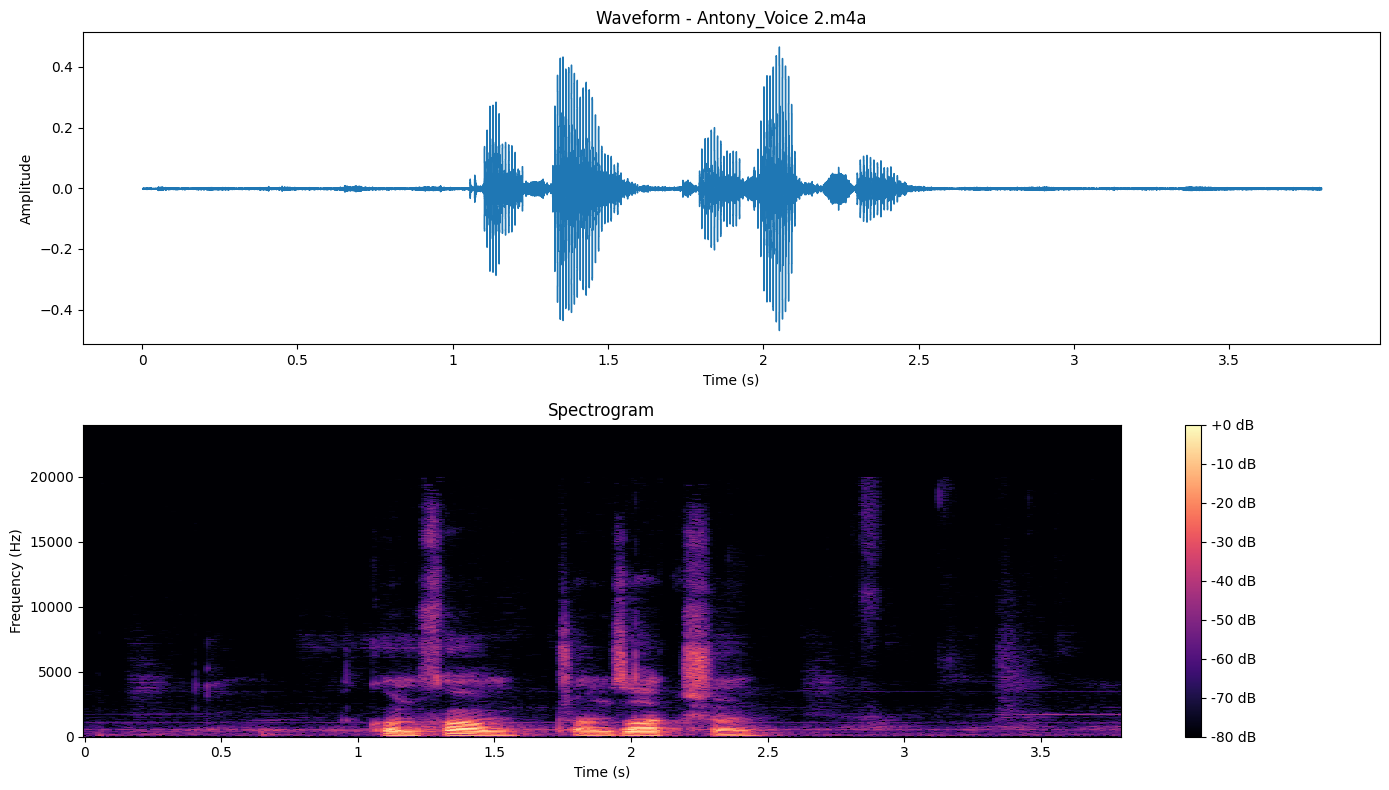

Audio player for: Antony_Voice 2.m4a


Duration: 3.80s, Sample Rate: 48000Hz



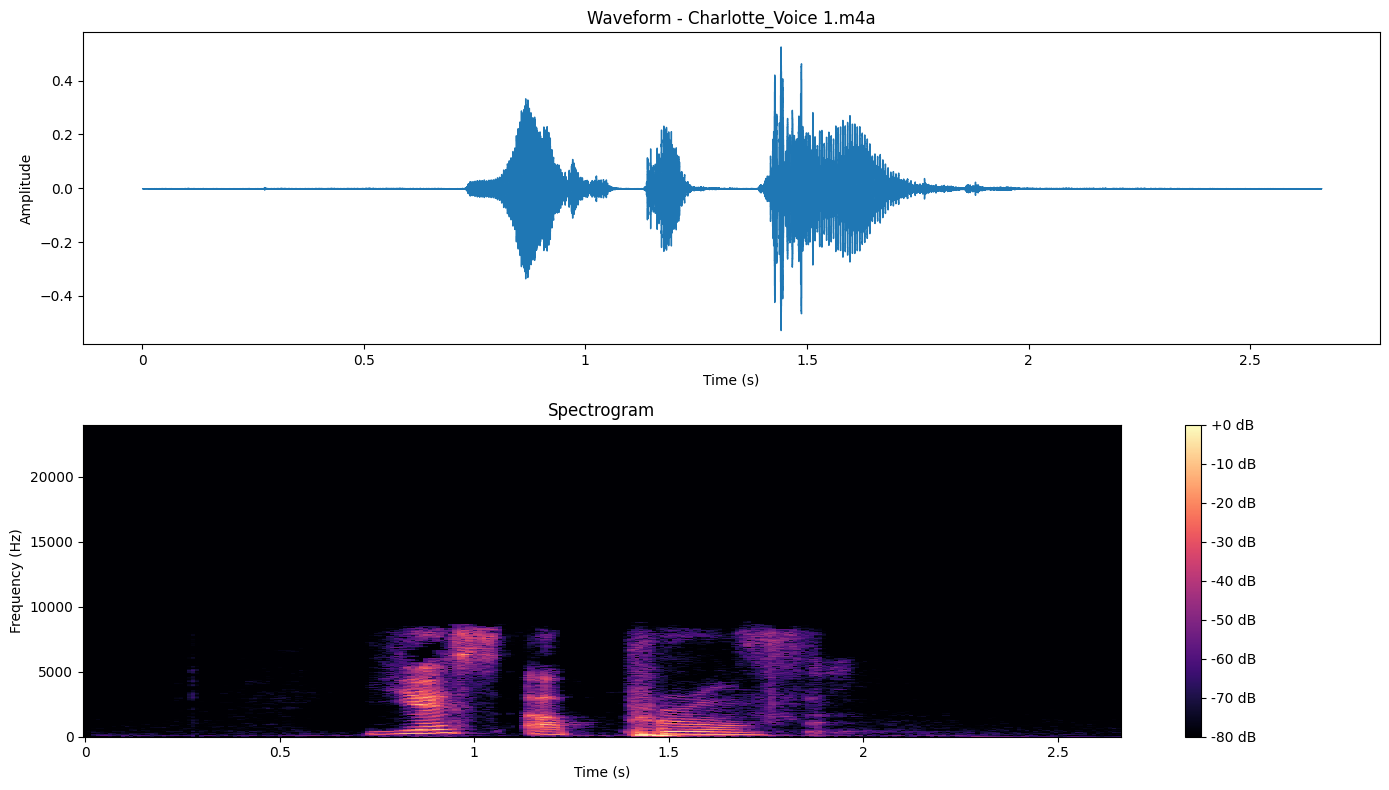

Audio player for: Charlotte_Voice 1.m4a


Duration: 2.66s, Sample Rate: 48000Hz



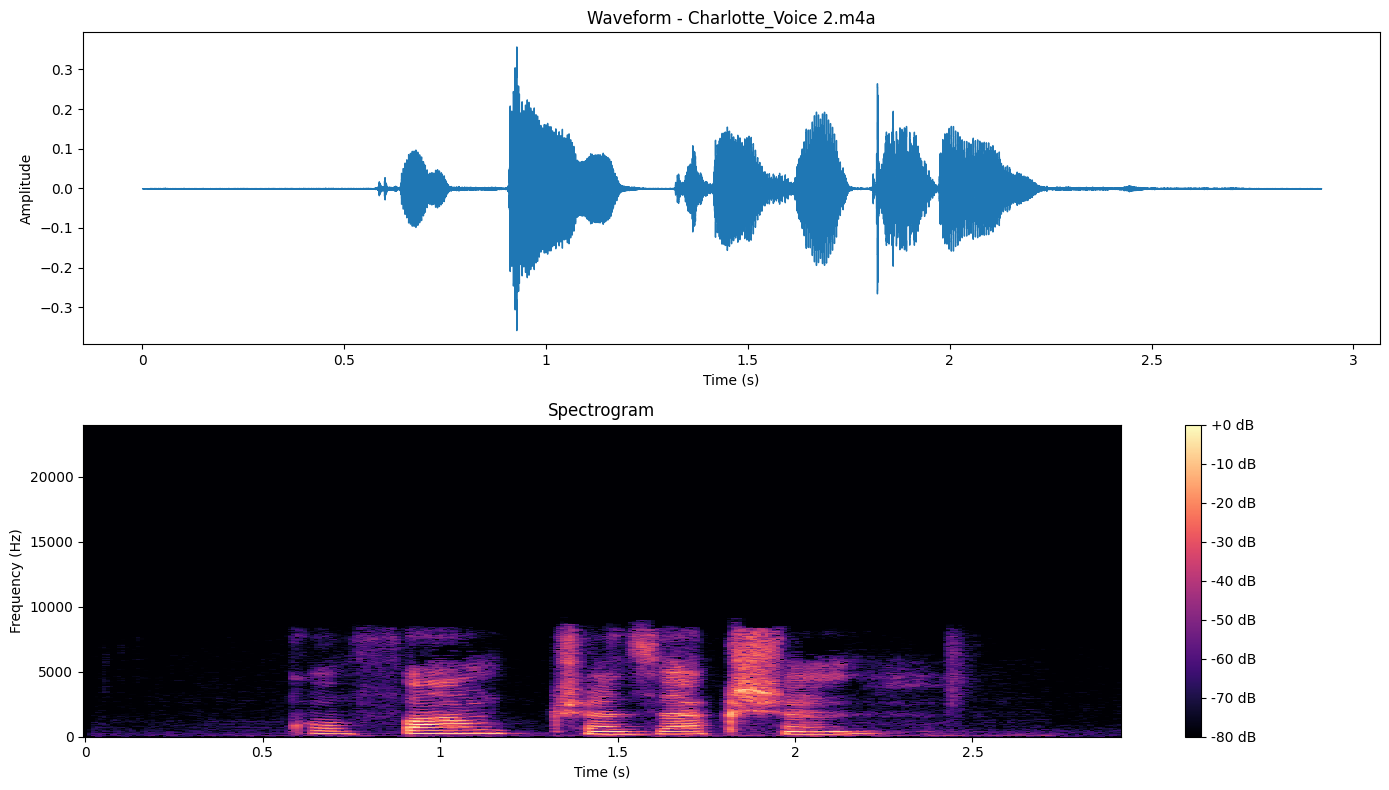

Audio player for: Charlotte_Voice 2.m4a


Duration: 2.92s, Sample Rate: 48000Hz



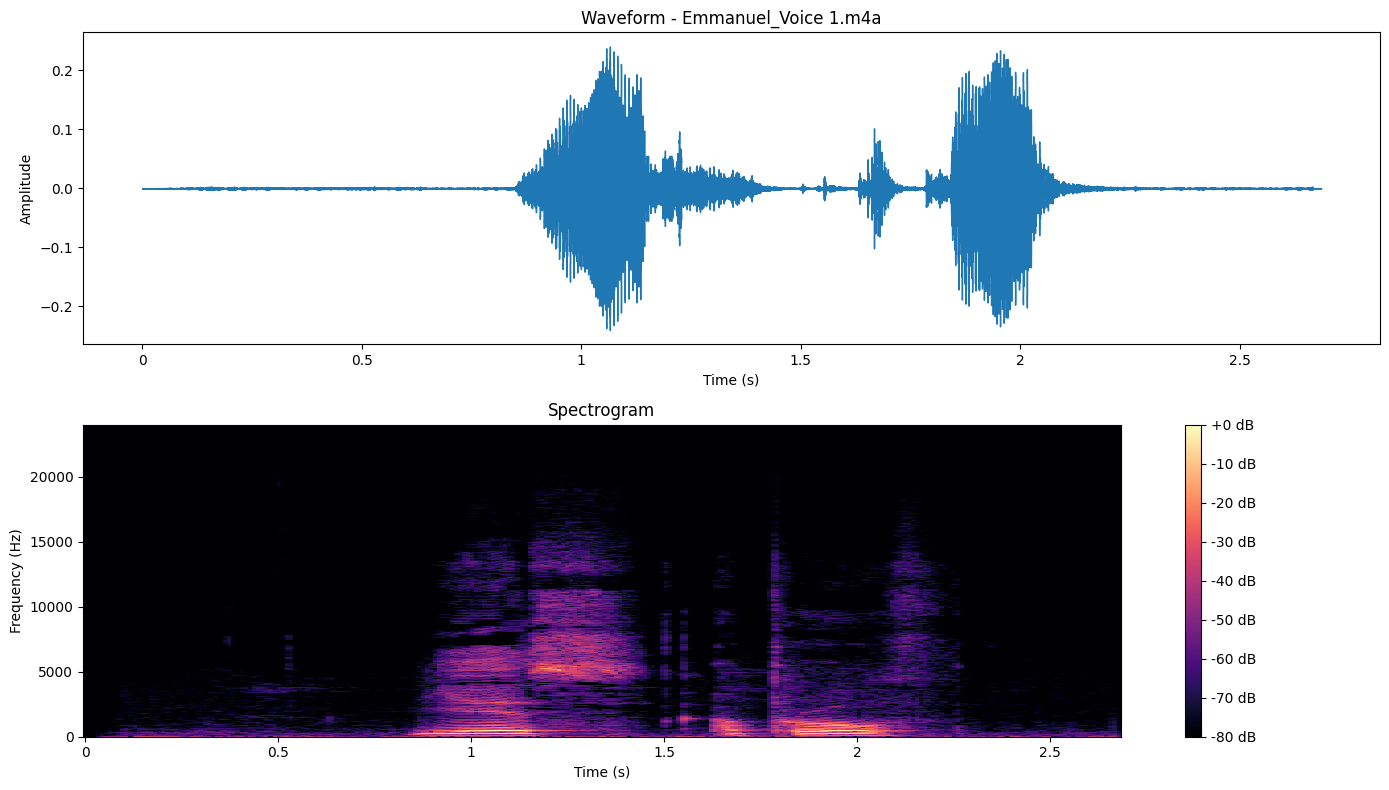

Audio player for: Emmanuel_Voice 1.m4a


Duration: 2.69s, Sample Rate: 48000Hz



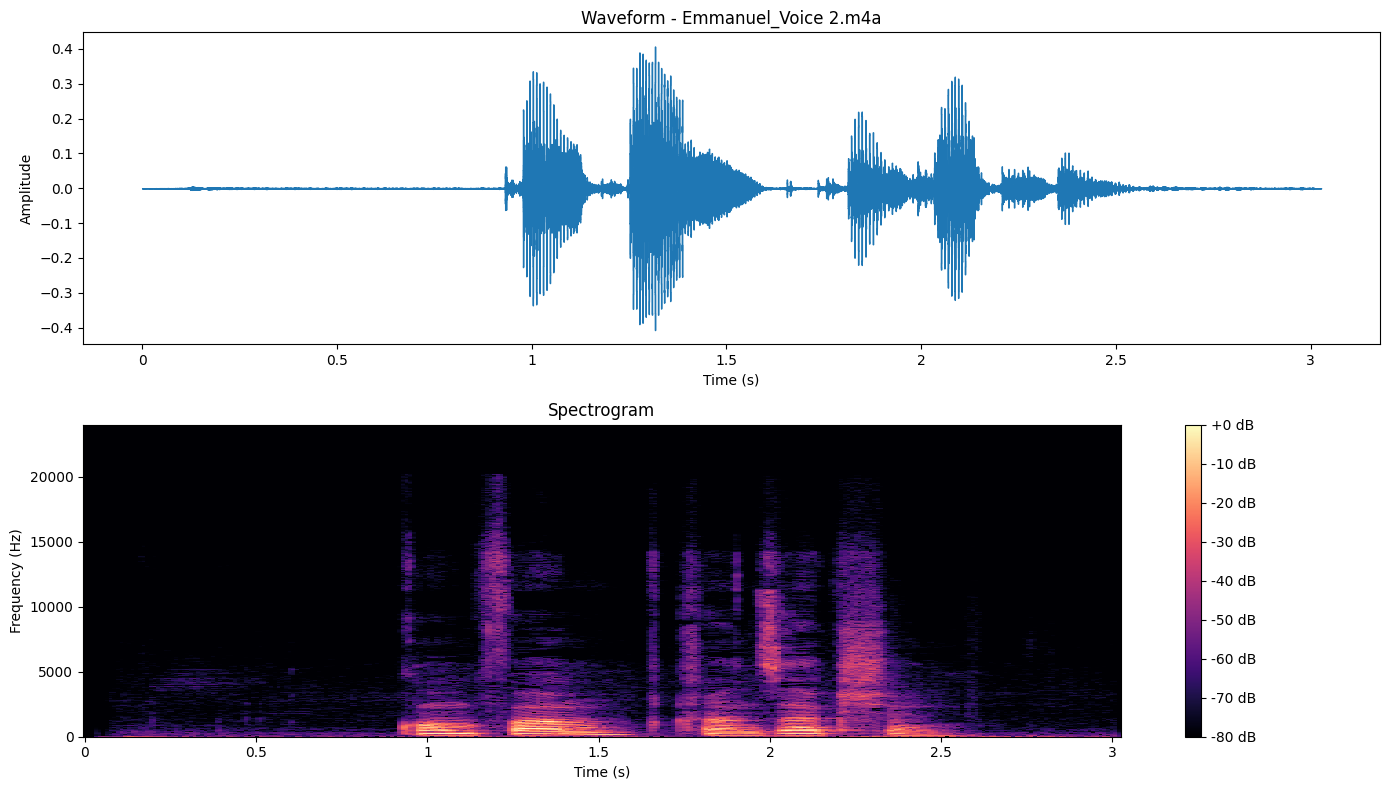

Audio player for: Emmanuel_Voice 2.m4a


Duration: 3.03s, Sample Rate: 48000Hz



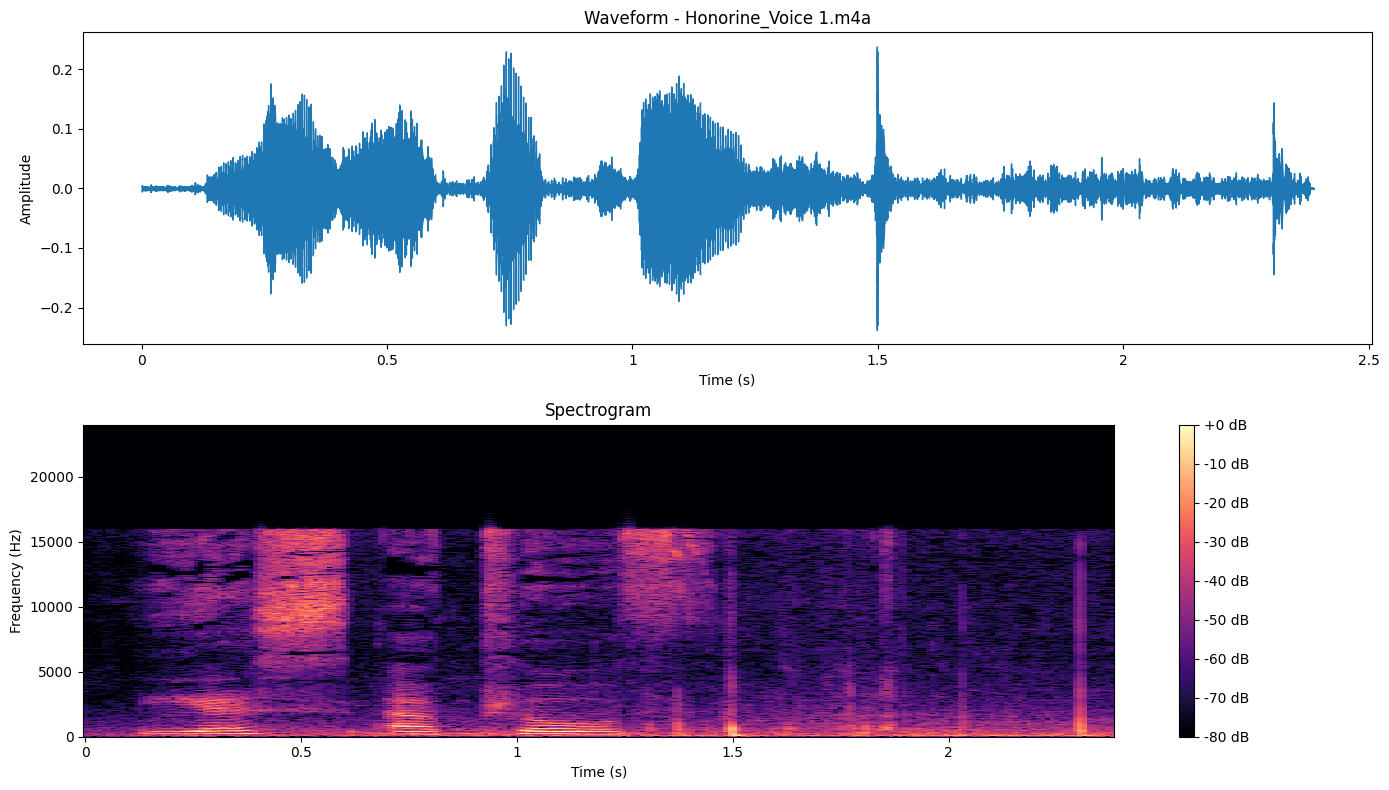

Audio player for: Honorine_Voice 1.m4a


Duration: 2.39s, Sample Rate: 48000Hz



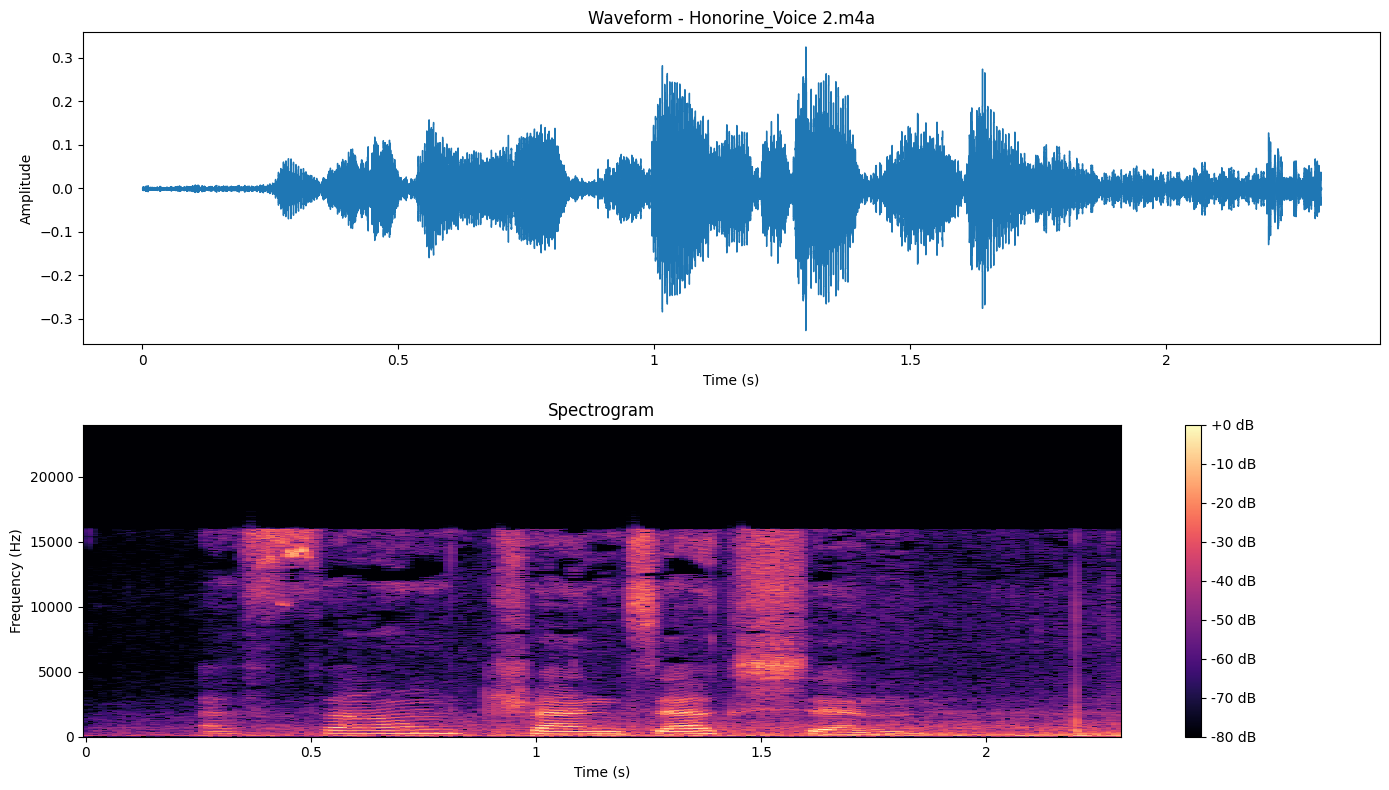

Audio player for: Honorine_Voice 2.m4a


Duration: 2.30s, Sample Rate: 48000Hz



In [19]:
def visualize_audio(file_path):
    """Display waveform and spectrogram for an audio file"""
    # Load audio
    y, sr = librosa.load(file_path, sr=None)

    # Create figure with subplots
    fig, axes = plt.subplots(2, 1, figsize=(14, 8))

    # Waveform
    librosa.display.waveshow(y, sr=sr, ax=axes[0])
    axes[0].set_title(f'Waveform - {os.path.basename(file_path)}')
    axes[0].set_xlabel('Time (s)')
    axes[0].set_ylabel('Amplitude')

    # Spectrogram
    D = librosa.amplitude_to_db(np.abs(librosa.stft(y)), ref=np.max)
    img = librosa.display.specshow(D, sr=sr, x_axis='time', y_axis='hz', ax=axes[1])
    axes[1].set_title('Spectrogram')
    axes[1].set_xlabel('Time (s)')
    axes[1].set_ylabel('Frequency (Hz)')
    fig.colorbar(img, ax=axes[1], format='%+2.0f dB')

    plt.tight_layout()
    plt.show()

    # Display audio player
    print(f"Audio player for: {os.path.basename(file_path)}")
    display(Audio(y, rate=sr))
    print(f"Duration: {len(y)/sr:.2f}s, Sample Rate: {sr}Hz\n")

# Visualize each audio file
print("\n" + "="*60)
print("VISUALIZING ALL AUDIO FILES")
print("="*60)
for file_path in audio_files:
    visualize_audio(file_path)

In [20]:
def pitch_shift_augmentation(y, sr, n_steps=2):
    """Shift pitch up or down by n_steps semitones"""
    return librosa.effects.pitch_shift(y, sr=sr, n_steps=n_steps)

def time_stretch_augmentation(y, rate=1.2):
    """Speed up (rate > 1) or slow down (rate < 1) audio"""
    return librosa.effects.time_stretch(y, rate=rate)

def add_noise_augmentation(y, noise_factor=0.005):
    """Add random background noise"""
    noise = np.random.randn(len(y))
    return y + noise_factor * noise

def apply_augmentations(file_path, output_dir="augmented_audio"):
    """Apply multiple augmentations to an audio file and save them"""
    # Create output directory
    os.makedirs(output_dir, exist_ok=True)

    # Load original audio
    y, sr = librosa.load(file_path, sr=None)
    base_name = os.path.splitext(os.path.basename(file_path))[0]

    augmented_files = []

    # Original file info
    augmented_files.append({
        'filename': base_name + '_original.wav',
        'augmentation': 'original',
        'audio': y,
        'sr': sr
    })

    # Augmentation 1: Pitch Shift (+2 semitones)
    y_pitch_up = pitch_shift_augmentation(y, sr, n_steps=2)
    augmented_files.append({
        'filename': base_name + '_pitch_up.wav',
        'augmentation': 'pitch_shift_+2',
        'audio': y_pitch_up,
        'sr': sr
    })

    # Augmentation 2: Pitch Shift (-2 semitones)
    y_pitch_down = pitch_shift_augmentation(y, sr, n_steps=-2)
    augmented_files.append({
        'filename': base_name + '_pitch_down.wav',
        'augmentation': 'pitch_shift_-2',
        'audio': y_pitch_down,
        'sr': sr
    })

    # Augmentation 3: Time Stretch (faster)
    y_faster = time_stretch_augmentation(y, rate=1.2)
    augmented_files.append({
        'filename': base_name + '_faster.wav',
        'augmentation': 'time_stretch_1.2x',
        'audio': y_faster,
        'sr': sr
    })

    # Augmentation 4: Time Stretch (slower)
    y_slower = time_stretch_augmentation(y, rate=0.8)
    augmented_files.append({
        'filename': base_name + '_slower.wav',
        'augmentation': 'time_stretch_0.8x',
        'audio': y_slower,
        'sr': sr
    })

    # Augmentation 5: Add Background Noise
    y_noisy = add_noise_augmentation(y, noise_factor=0.005)
    augmented_files.append({
        'filename': base_name + '_noisy.wav',
        'augmentation': 'background_noise',
        'audio': y_noisy,
        'sr': sr
    })

    # Save all augmented files
    for aug_file in augmented_files:
        output_path = os.path.join(output_dir, aug_file['filename'])
        sf.write(output_path, aug_file['audio'], aug_file['sr'])

    return augmented_files

# Apply augmentations to all audio files
print("\n" + "="*60)
print("APPLYING AUGMENTATIONS")
print("="*60)

all_augmented = []
for file_path in audio_files:
    print(f"\nProcessing: {os.path.basename(file_path)}")
    augmented = apply_augmentations(file_path)
    all_augmented.extend(augmented)
    print(f"  Created {len(augmented)} versions (1 original + {len(augmented)-1} augmentations)")

print(f"\nTotal audio files (original + augmented): {len(all_augmented)}")


APPLYING AUGMENTATIONS

Processing: Antony_Voice 1.m4a
  Created 6 versions (1 original + 5 augmentations)

Processing: Antony_Voice 2.m4a
  Created 6 versions (1 original + 5 augmentations)

Processing: Charlotte_Voice 1.m4a
  Created 6 versions (1 original + 5 augmentations)

Processing: Charlotte_Voice 2.m4a
  Created 6 versions (1 original + 5 augmentations)

Processing: Emmanuel_Voice 1.m4a
  Created 6 versions (1 original + 5 augmentations)

Processing: Emmanuel_Voice 2.m4a
  Created 6 versions (1 original + 5 augmentations)

Processing: Honorine_Voice 1.m4a
  Created 6 versions (1 original + 5 augmentations)

Processing: Honorine_Voice 2.m4a
  Created 6 versions (1 original + 5 augmentations)

Total audio files (original + augmented): 48


In [21]:
def extract_features(y, sr):
    """Extract audio features: MFCCs, Spectral Roll-off, Energy"""
    features = {}

    # MFCCs (13 coefficients)
    mfccs = librosa.feature.mfcc(y=y, sr=sr, n_mfcc=13)
    for i in range(13):
        features[f'mfcc_{i+1}_mean'] = np.mean(mfccs[i])
        features[f'mfcc_{i+1}_std'] = np.std(mfccs[i])

    # Spectral Roll-off
    rolloff = librosa.feature.spectral_rolloff(y=y, sr=sr)
    features['spectral_rolloff_mean'] = np.mean(rolloff)
    features['spectral_rolloff_std'] = np.std(rolloff)

    # Energy (RMS)
    energy = librosa.feature.rms(y=y)
    features['energy_mean'] = np.mean(energy)
    features['energy_std'] = np.std(energy)

    # Additional useful features
    features['zero_crossing_rate'] = np.mean(librosa.feature.zero_crossing_rate(y))
    features['spectral_centroid'] = np.mean(librosa.feature.spectral_centroid(y=y, sr=sr))

    return features

# Extract features from all augmented files
print("\n" + "="*60)
print("EXTRACTING FEATURES")
print("="*60)

features_list = []

for aug_file in all_augmented:
    print(f"Extracting features from: {aug_file['filename']}")

    # Extract features
    features = extract_features(aug_file['audio'], aug_file['sr'])

    # Add metadata
    features['filename'] = aug_file['filename']
    features['augmentation'] = aug_file['augmentation']
    features['duration'] = len(aug_file['audio']) / aug_file['sr']
    features['sample_rate'] = aug_file['sr']

    features_list.append(features)

# Create DataFrame
df_features = pd.DataFrame(features_list)

# Reorder columns to put metadata first
metadata_cols = ['filename', 'augmentation', 'duration', 'sample_rate']
feature_cols = [col for col in df_features.columns if col not in metadata_cols]
df_features = df_features[metadata_cols + feature_cols]

# Save to CSV
output_csv = "../data/audio_features.csv"
df_features.to_csv(output_csv, index=False)

print(f"\n✓ Features extracted and saved to '{output_csv}'")
print(f"✓ Total samples: {len(df_features)}")
print(f"✓ Total features per sample: {len(feature_cols)}")

# Display first few rows
print("\nPreview of extracted features:")
print(df_features.head())

# Display summary statistics
print("\nFeature Statistics:")
print(df_features[feature_cols].describe())

print("\n" + "="*60)
print("PIPELINE COMPLETE!")
print("="*60)
print(f"✓ Visualized {len(audio_files)} original audio files")
print(f"✓ Created {len(all_augmented) - len(audio_files)} augmented samples")
print(f"✓ Extracted features from {len(all_augmented)} total samples")
print(f"✓ Saved features to '{output_csv}'")


EXTRACTING FEATURES
Extracting features from: Antony_Voice 1_original.wav
Extracting features from: Antony_Voice 1_pitch_up.wav
Extracting features from: Antony_Voice 1_pitch_down.wav
Extracting features from: Antony_Voice 1_faster.wav
Extracting features from: Antony_Voice 1_slower.wav
Extracting features from: Antony_Voice 1_noisy.wav
Extracting features from: Antony_Voice 2_original.wav
Extracting features from: Antony_Voice 2_pitch_up.wav
Extracting features from: Antony_Voice 2_pitch_down.wav
Extracting features from: Antony_Voice 2_faster.wav
Extracting features from: Antony_Voice 2_slower.wav
Extracting features from: Antony_Voice 2_noisy.wav
Extracting features from: Charlotte_Voice 1_original.wav
Extracting features from: Charlotte_Voice 1_pitch_up.wav
Extracting features from: Charlotte_Voice 1_pitch_down.wav
Extracting features from: Charlotte_Voice 1_faster.wav
Extracting features from: Charlotte_Voice 1_slower.wav
Extracting features from: Charlotte_Voice 1_noisy.wav
Extr

# Voiceprint Verification Model

In [24]:
# Load the Audio Features Dataset
print("="*60)
print("LOADING AUDIO FEATURES DATASET")
print("="*60)

df = pd.read_csv('../data/audio_features.csv')
print(f"\nDataset shape: {df.shape}")
print(f"Number of samples: {len(df)}")

# Check if 'speaker' column exists, if not extract it from filename
if 'speaker' not in df.columns:
    print("\n'speaker' column not found. Extracting from filenames...")
    df['speaker'] = df['filename'].apply(lambda x: x.split('_')[0])
    print("✓ Speaker column created")

print(f"\nSpeakers in dataset:")
print(df['speaker'].value_counts())
print(f"\nAugmentation types:")
print(df['augmentation'].value_counts())

LOADING AUDIO FEATURES DATASET

Dataset shape: (48, 36)
Number of samples: 48

'speaker' column not found. Extracting from filenames...
✓ Speaker column created

Speakers in dataset:
speaker
Antony       12
Charlotte    12
Emmanuel     12
Honorine     12
Name: count, dtype: int64

Augmentation types:
augmentation
original             8
pitch_shift_+2       8
pitch_shift_-2       8
time_stretch_1.2x    8
time_stretch_0.8x    8
background_noise     8
Name: count, dtype: int64


In [23]:
# Display first few rows
print(df.head())

                        filename       augmentation  duration  sample_rate  \
0    Antony_Voice 1_original.wav           original  3.753333        48000   
1    Antony_Voice 1_pitch_up.wav     pitch_shift_+2  3.753333        48000   
2  Antony_Voice 1_pitch_down.wav     pitch_shift_-2  3.753333        48000   
3      Antony_Voice 1_faster.wav  time_stretch_1.2x  3.127771        48000   
4      Antony_Voice 1_slower.wav  time_stretch_0.8x  4.691667        48000   

   mfcc_1_mean  mfcc_1_std  mfcc_2_mean  mfcc_2_std  mfcc_3_mean  mfcc_3_std  \
0  -520.976868   79.451340   123.352196   49.939140    47.812462   20.820370   
1  -553.119324   82.535255   123.236061   50.624065    43.405682   19.464411   
2  -558.807983   75.533134   112.336151   48.634315    48.425175   22.434887   
3  -575.521912   86.968040   137.069931   49.037918    45.181099   22.106165   
4  -548.974976   76.258965   112.281860   49.266335    46.826656   19.595715   

   ...  mfcc_12_std  mfcc_13_mean  mfcc_13_std  sp

In [25]:
# Data Preparation
print("\n" + "="*60)
print("DATA PREPARATION")
print("="*60)

# Separate features and target
feature_cols = [col for col in df.columns if col not in 
                ['filename', 'speaker', 'augmentation', 'duration', 'sample_rate']]

X = df[feature_cols]
y = df['speaker']

print(f"\nFeatures used: {len(feature_cols)}")
print(f"Feature names: {feature_cols[:5]}... (showing first 5)")

# Encode speaker names to numeric labels
label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(y)

print(f"\nSpeaker encoding:")
for i, speaker in enumerate(label_encoder.classes_):
    print(f"  {speaker} -> {i}")

# Check for missing values
print(f"\nMissing values: {X.isnull().sum().sum()}")


DATA PREPARATION

Features used: 32
Feature names: ['mfcc_1_mean', 'mfcc_1_std', 'mfcc_2_mean', 'mfcc_2_std', 'mfcc_3_mean']... (showing first 5)

Speaker encoding:
  Antony -> 0
  Charlotte -> 1
  Emmanuel -> 2
  Honorine -> 3

Missing values: 0


In [26]:
# Spliting data into Train-Test sets
X_train, X_test, y_train, y_test = train_test_split(
    X, y_encoded, test_size=0.2, random_state=42, stratify=y_encoded
)

print(f"Training set size: {len(X_train)} samples")
print(f"Test set size: {len(X_test)} samples")
print(f"\nTraining set speaker distribution:")
for i, speaker in enumerate(label_encoder.classes_):
    count = np.sum(y_train == i)
    print(f"  {speaker}: {count} samples")


Training set size: 38 samples
Test set size: 10 samples

Training set speaker distribution:
  Antony: 9 samples
  Charlotte: 10 samples
  Emmanuel: 9 samples
  Honorine: 10 samples


In [28]:
# Feature Scaling
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

print("✓ Features normalized using StandardScaler")

✓ Features normalized using StandardScaler


In [29]:
# Model Training
models = {}
results = {}

# Model 1: Random Forest
print("\n[1/3] Training Random Forest Classifier...")
rf_model = RandomForestClassifier(
    n_estimators=100,
    max_depth=10,
    random_state=42,
    n_jobs=-1
)
rf_model.fit(X_train_scaled, y_train)
models['Random Forest'] = rf_model
print("✓ Random Forest trained")

# Model 2: Logistic Regression
print("\n[2/3] Training Logistic Regression...")
lr_model = LogisticRegression(
    max_iter=1000,
    random_state=42,
    multi_class='ovr'
)
lr_model.fit(X_train_scaled, y_train)
models['Logistic Regression'] = lr_model
print("✓ Logistic Regression trained")

# Model 3: Gradient Boosting
print("\n[3/3] Training Gradient Boosting Classifier...")
gb_model = GradientBoostingClassifier(
    n_estimators=100,
    max_depth=5,
    learning_rate=0.1,
    random_state=42
)
gb_model.fit(X_train_scaled, y_train)
models['Gradient Boosting'] = gb_model
print("✓ Gradient Boosting trained")


[1/3] Training Random Forest Classifier...
✓ Random Forest trained

[2/3] Training Logistic Regression...
✓ Logistic Regression trained

[3/3] Training Gradient Boosting Classifier...
✓ Gradient Boosting trained



MODEL EVALUATION

RANDOM FOREST RESULTS

Accuracy: 0.8000 (80.00%)
F1-Score: 0.7750
Recall: 0.8000
AUC-ROC: 0.9143

Classification Report:
              precision    recall  f1-score   support

      Antony     0.6000    1.0000    0.7500         3
   Charlotte     1.0000    1.0000    1.0000         2
    Emmanuel     1.0000    0.3333    0.5000         3
    Honorine     1.0000    1.0000    1.0000         2

    accuracy                         0.8000        10
   macro avg     0.9000    0.8333    0.8125        10
weighted avg     0.8800    0.8000    0.7750        10



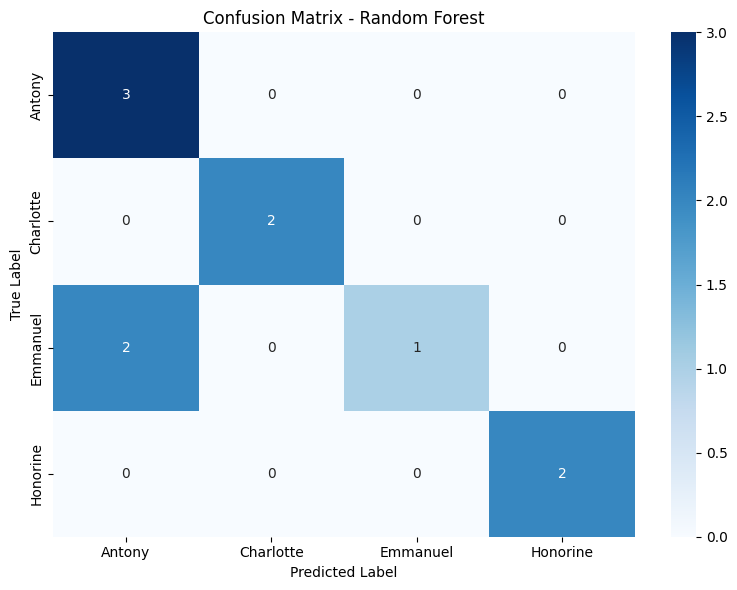


LOGISTIC REGRESSION RESULTS

Accuracy: 0.8000 (80.00%)
F1-Score: 0.7671
Recall: 0.8000
AUC-ROC: 0.9286

Classification Report:
              precision    recall  f1-score   support

      Antony     0.7500    1.0000    0.8571         3
   Charlotte     0.6667    1.0000    0.8000         2
    Emmanuel     1.0000    0.3333    0.5000         3
    Honorine     1.0000    1.0000    1.0000         2

    accuracy                         0.8000        10
   macro avg     0.8542    0.8333    0.7893        10
weighted avg     0.8583    0.8000    0.7671        10



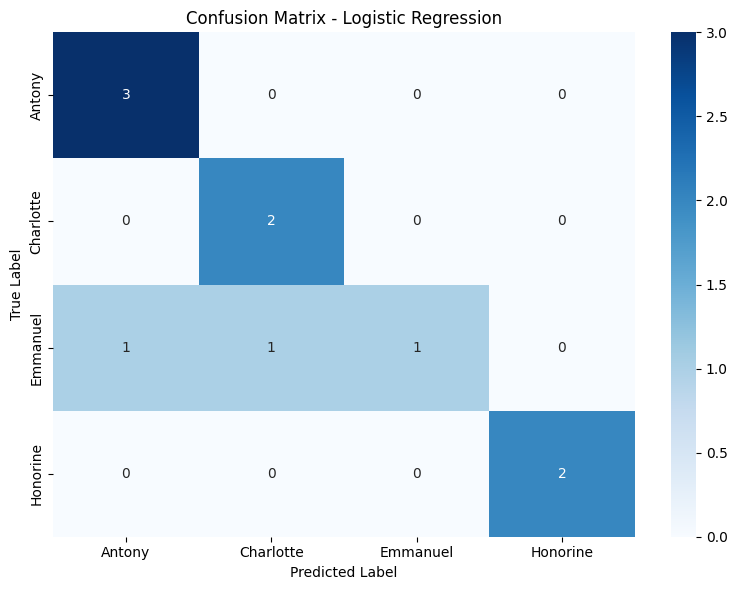


GRADIENT BOOSTING RESULTS

Accuracy: 0.7000 (70.00%)
F1-Score: 0.6814
Recall: 0.7000
AUC-ROC: 0.7857

Classification Report:
              precision    recall  f1-score   support

      Antony     0.5000    0.6667    0.5714         3
   Charlotte     0.6667    1.0000    0.8000         2
    Emmanuel     1.0000    0.3333    0.5000         3
    Honorine     1.0000    1.0000    1.0000         2

    accuracy                         0.7000        10
   macro avg     0.7917    0.7500    0.7179        10
weighted avg     0.7833    0.7000    0.6814        10



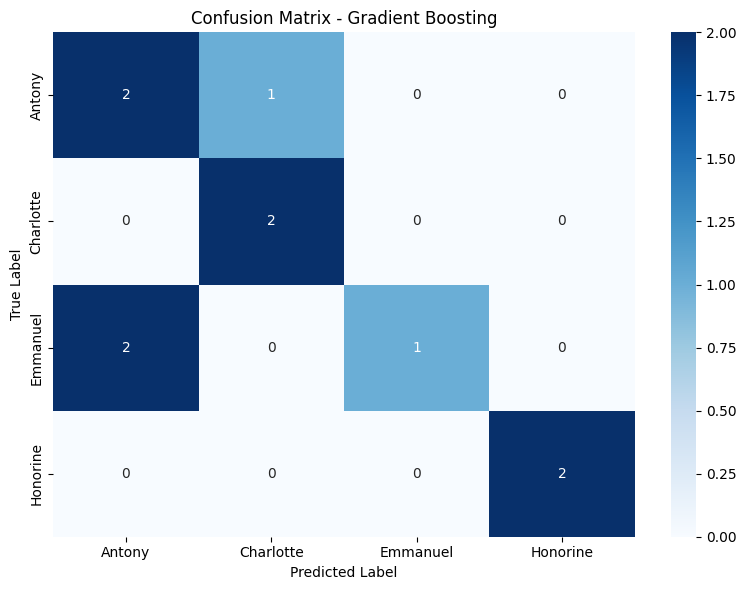

In [30]:
# Models Evaluation
print("\n" + "="*60)
print("MODEL EVALUATION")
print("="*60)

for model_name, model in models.items():
    print(f"\n{'='*60}")
    print(f"{model_name.upper()} RESULTS")
    print(f"{'='*60}")
    
    # Predictions
    y_pred = model.predict(X_test_scaled)
    y_pred_proba = model.predict_proba(X_test_scaled)
    
    # Calculate metrics
    accuracy = accuracy_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred, average='weighted')
    recall = recall_score(y_test, y_pred, average='weighted')
    
    # Calculate AUC (multi-class)
    try:
        auc = roc_auc_score(y_test, y_pred_proba, multi_class='ovr', average='weighted')
    except:
        auc = None
    
    # Store results
    results[model_name] = {
        'accuracy': accuracy,
        'f1_score': f1,
        'recall': recall,
        'auc': auc,
        'predictions': y_pred,
        'probabilities': y_pred_proba
    }
    
    # Print metrics
    print(f"\nAccuracy: {accuracy:.4f} ({accuracy*100:.2f}%)")
    print(f"F1-Score: {f1:.4f}")
    print(f"Recall: {recall:.4f}")
    if auc:
        print(f"AUC-ROC: {auc:.4f}")
    
    # Classification Report
    print(f"\nClassification Report:")
    print(classification_report(y_test, y_pred, 
                                target_names=label_encoder.classes_,
                                digits=4))
    
    # Confusion Matrix
    cm = confusion_matrix(y_test, y_pred)
    
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=label_encoder.classes_,
                yticklabels=label_encoder.classes_)
    plt.title(f'Confusion Matrix - {model_name}')
    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')
    plt.tight_layout()
    plt.show()


MODEL COMPARISON

               Model  Accuracy  F1-Score  Recall  AUC-ROC
      Random Forest       0.8  0.775000     0.8 0.914286
Logistic Regression       0.8  0.767143     0.8 0.928571
  Gradient Boosting       0.7  0.681429     0.7 0.785714


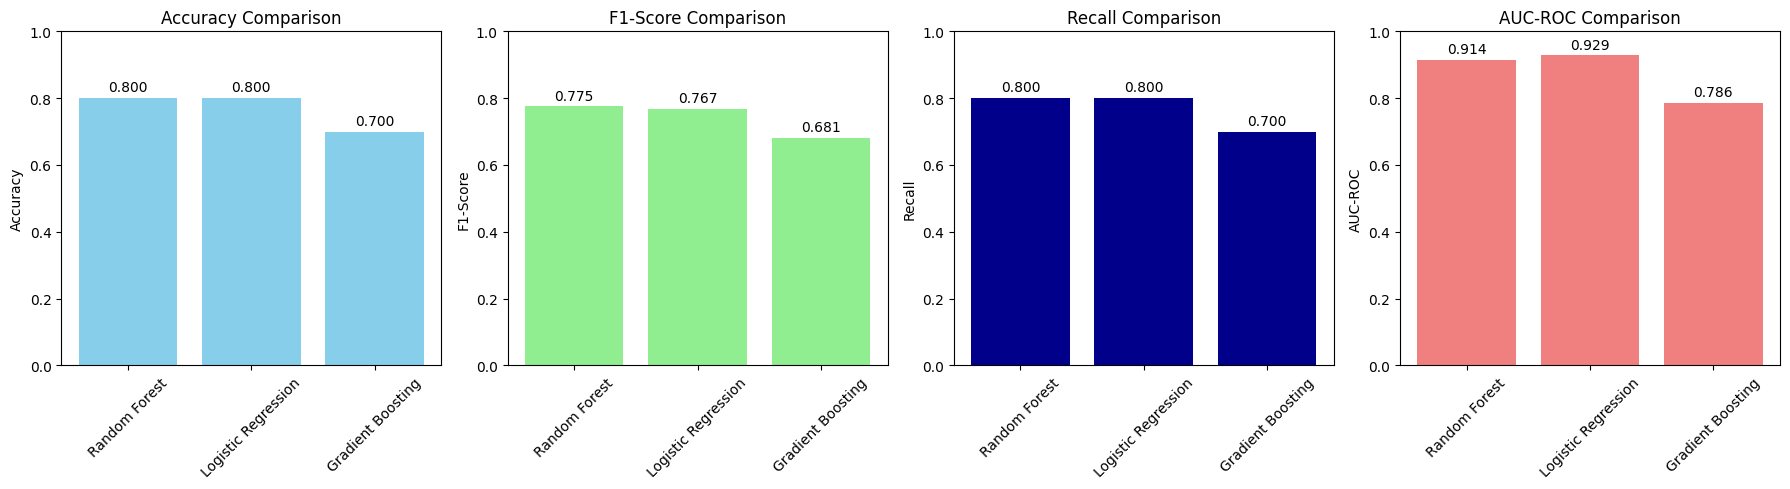

In [32]:
# Models Comparison
print("\n" + "="*60)
print("MODEL COMPARISON")
print("="*60)

comparison_df = pd.DataFrame({
    'Model': list(results.keys()),
    'Accuracy': [results[m]['accuracy'] for m in results.keys()],
    'F1-Score': [results[m]['f1_score'] for m in results.keys()],
    'Recall': [results[m]['recall'] for m in results.keys()],
    'AUC-ROC': [results[m]['auc'] if results[m]['auc'] else 0 for m in results.keys()]
})

print("\n", comparison_df.to_string(index=False))

# Visualize comparison
fig, axes = plt.subplots(1, 4, figsize=(18, 5))

# Accuracy
axes[0].bar(comparison_df['Model'], comparison_df['Accuracy'], color='skyblue')
axes[0].set_title('Accuracy Comparison')
axes[0].set_ylabel('Accuracy')
axes[0].set_ylim([0, 1])
axes[0].tick_params(axis='x', rotation=45)
for i, v in enumerate(comparison_df['Accuracy']):
    axes[0].text(i, v + 0.02, f'{v:.3f}', ha='center')

# F1-Score
axes[1].bar(comparison_df['Model'], comparison_df['F1-Score'], color='lightgreen')
axes[1].set_title('F1-Score Comparison')
axes[1].set_ylabel('F1-Score')
axes[1].set_ylim([0, 1])
axes[1].tick_params(axis='x', rotation=45)
for i, v in enumerate(comparison_df['F1-Score']):
    axes[1].text(i, v + 0.02, f'{v:.3f}', ha='center')

# Recall
axes[2].bar(comparison_df['Model'], comparison_df['Recall'], color='darkblue')
axes[2].set_title('Recall Comparison')
axes[2].set_ylabel('Recall')
axes[2].set_ylim([0, 1])
axes[2].tick_params(axis='x', rotation=45)
for i, v in enumerate(comparison_df['Recall']):
    axes[2].text(i, v + 0.02, f'{v:.3f}', ha='center')

# AUC-ROC
axes[3].bar(comparison_df['Model'], comparison_df['AUC-ROC'], color='lightcoral')
axes[3].set_title('AUC-ROC Comparison')
axes[3].set_ylabel('AUC-ROC')
axes[3].set_ylim([0, 1])
axes[3].tick_params(axis='x', rotation=45)
for i, v in enumerate(comparison_df['AUC-ROC']):
    if v > 0:
        axes[3].text(i, v + 0.02, f'{v:.3f}', ha='center')

plt.tight_layout()
plt.show()

From this we can see that the model that is performing well on the audios provided is Logistic Regression while Gradient Boosting is the one that is performing the worse among the 3 used models.